# Stroke Prediction

The data is strongly imbalanced in this case: We have 4861 patients with target=0 (no stroke), but only 249 (<5%) cases with target=1 (stroke). By using a trivial predictor which always returns 0 we can achieve an accuracy of 4861/5110 = 95.13%. This sounds at first like a good performance, however, this trivial predictor is completely useless as it has absolutely no discriminative power. We can see that accuracy is not a really useful metric in the context of strongly imbalanced data. In the following we will - for the sake of completeness - evaluate also accuracy but our focus will be on AUC as performance metric instead (our trivial predictor would have an AUC of 0.5).

In [1]:
# standard
import numpy as np
import pandas as pd
import time

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# statistics tools
from statsmodels.graphics.mosaicplot import mosaic

# ML
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OGradientBoostingEstimator

# Import and First Glance

In [2]:
# load data
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
# dimensions of data
df.shape

(5110, 12)

In [4]:
# column names
print(df.columns.tolist())

['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


# Data Cleansing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


We have missing values for Body Mass Index (BMI).

In [6]:
# impute with -99
df.bmi = df.bmi.fillna(-99)

In [7]:
# rename columns
df.rename(columns = {'Residence_type':'residence_type'}, inplace = True)

In [8]:
# define target variable
df['target'] = df.stroke
df = df.drop(['stroke'], axis=1) # remove stroke column

# Numerical Features

In [9]:
# select numerical features
features_num = ['age', 'avg_glucose_level','bmi']

In [10]:
# basic stats
df[features_num].describe(percentiles=[0.1,0.25,0.5,0.75,0.9])

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000
mean,43.226614,106.147677,23.862603
std,22.612647,45.283560,26.028009
min,0.080000,55.120000,-99.000000
10%,11.000000,65.789000,18.290000
25%,25.000000,77.245000,22.900000
50%,45.000000,91.885000,27.700000
75%,61.000000,114.090000,32.800000
90%,75.000000,192.181000,38.700000
max,82.000000,271.740000,97.600000


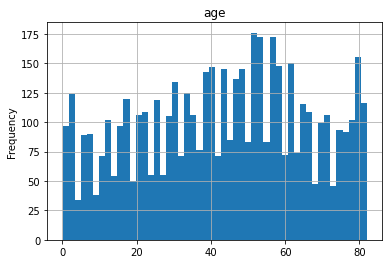

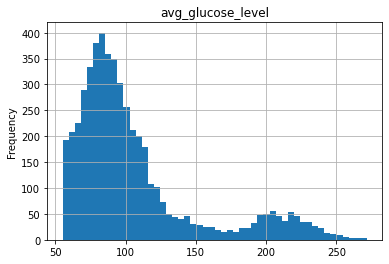

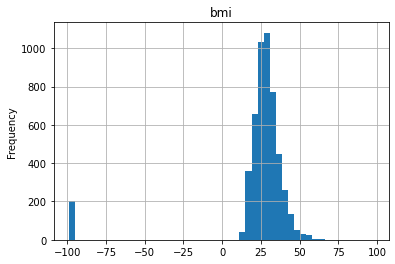

In [11]:
# plot distribution of numerical features
for f in features_num:
    df[f].plot(kind='hist', bins=50)
    plt.title(f)
    plt.grid()
    plt.show()

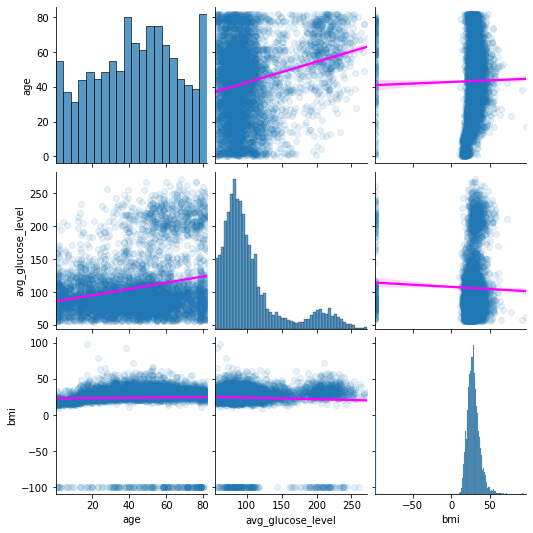

In [12]:
# pairwise scatter plot
sns.pairplot(df[features_num], 
             kind='reg', 
             plot_kws={'line_kws':{'color':'magenta'}, 'scatter_kws': {'alpha': 0.1}})
plt.show()

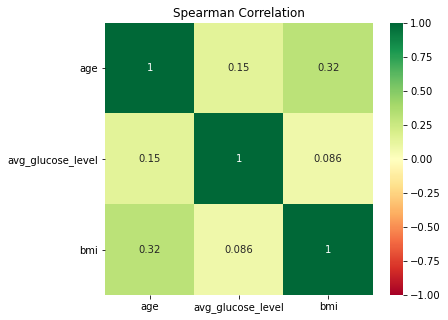

In [13]:
# Spearman (Rank) correlation
corr_spearman = df[features_num].corr(method='spearman')

fig = plt.figure(figsize = (6,5))
sns.heatmap(corr_spearman, annot=True, cmap="RdYlGn", vmin=-1, vmax=+1)
plt.title('Spearman Correlation')
plt.show()

# Categorical Features

In [14]:
features_cat = ['gender','hypertension','heart_disease','ever_married',
                'work_type','residence_type','smoking_status']

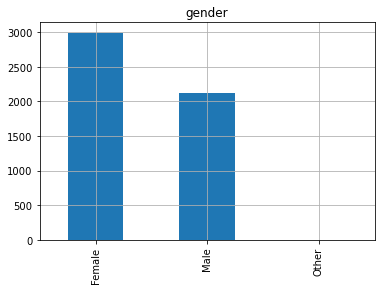

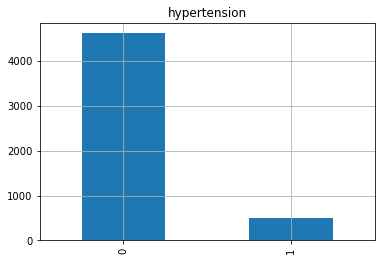

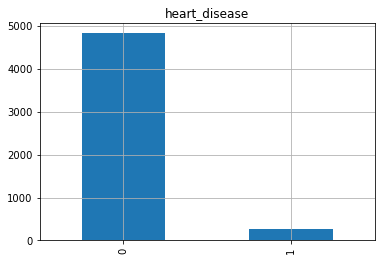

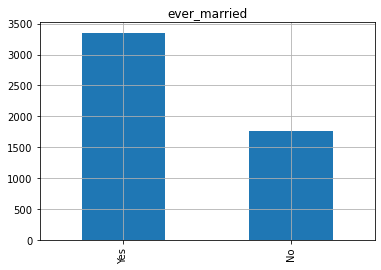

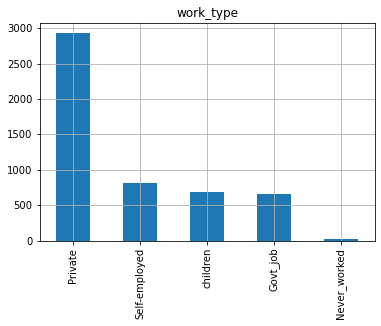

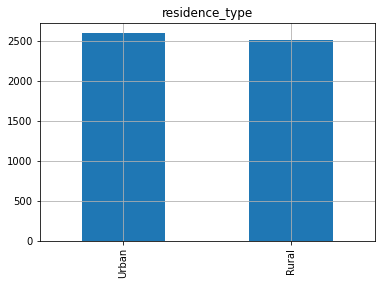

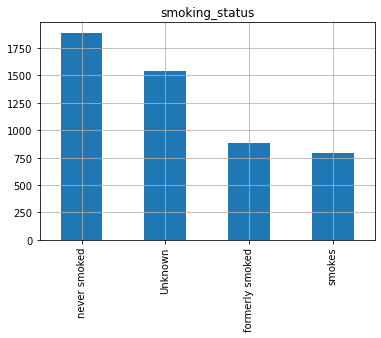

In [15]:
for f in features_cat:
    df[f].value_counts().plot(kind='bar')
    plt.title(f)
    plt.grid()
    plt.show()

# Target

In [16]:
# calc frequencies
target_count = df.target.value_counts()
print(target_count)
print()
print('Percentage of strokes [1]:', np.round(100*target_count[1] / target_count.sum(),2), '%')

0    4861
1     249
Name: target, dtype: int64

Percentage of strokes [1]: 4.87 %


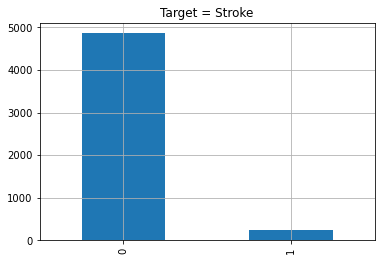

In [17]:
# plot target distribution
target_count.plot(kind='bar')
plt.title('Target = Stroke')
plt.grid()
plt.show()

### Target vs Numerical Features

In [18]:
# add binned version of numerical features

# quantile based:
df['age_bin'] = pd.qcut(df['age'], q=10, precision=1)
df['avg_glucose_level_bin'] = pd.qcut(df['avg_glucose_level'], q=10, precision=1)

# explicitly defined bins:
df['bmi_bin'] = pd.cut(df['bmi'], [-100,10,20,25,30,35,40,50,100])

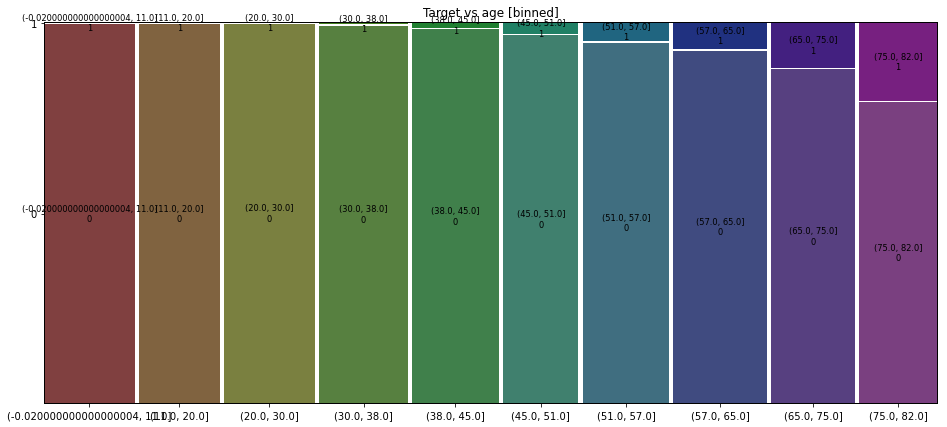

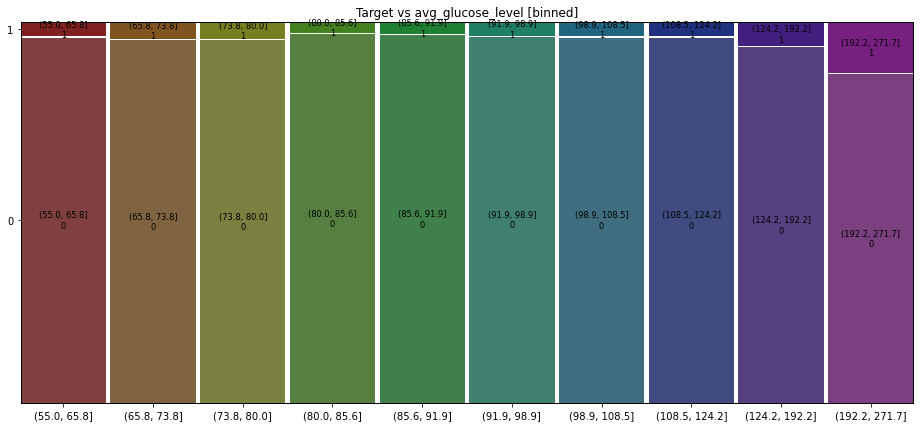

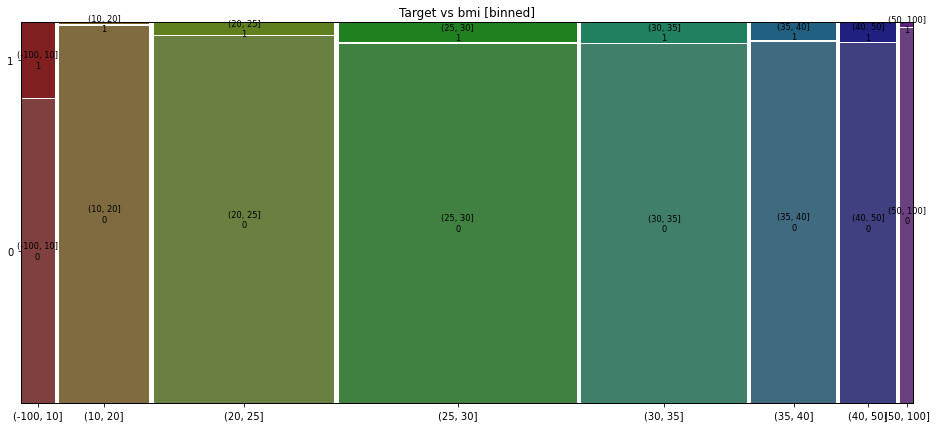

In [19]:
# plot target vs features using mosaic plot
plt_para_save = plt.rcParams['figure.figsize'] # remember plot settings

for f in features_num:
    f_bin = f+'_bin'
    plt.rcParams["figure.figsize"] = (16,7) # increase plot size for mosaics
    mosaic(df, [f_bin, 'target'], title='Target vs ' + f + ' [binned]')
    plt.show()
    
# reset plot size again
plt.rcParams['figure.figsize'] = plt_para_save

"Naive" interpretations based on those univariate plots:
- Risk increases with age and glucose level (diabetes).
- High BMI levels are also indicating higher risk.
- A missing value for BMI (the leftmost column) seems to indicate a massively increased risk.

In [20]:
# BMI - check cross table
ctab = pd.crosstab(df.bmi_bin, df.target)
ctab

target,0,1
bmi_bin,,
"(-100, 10]",161,40
"(10, 20]",534,3
"(20, 25]",1035,35
"(25, 30]",1334,75
"(30, 35]",931,54
"(35, 40]",476,24
"(40, 50]",312,17
"(50, 100]",78,1


In [21]:
# normalize each row to get row-wise target percentages
(ctab.transpose() / ctab.sum(axis=1)).transpose()

target,0,1
bmi_bin,,
"(-100, 10]",0.800995,0.199005
"(10, 20]",0.994413,0.005587
"(20, 25]",0.967290,0.032710
"(25, 30]",0.946771,0.053229
"(30, 35]",0.945178,0.054822
"(35, 40]",0.952000,0.048000
"(40, 50]",0.948328,0.051672
"(50, 100]",0.987342,0.012658


Almost 20% of the missing BMI had a stroke. This is way higher than for the other bins.

### Target vs Categorical Features

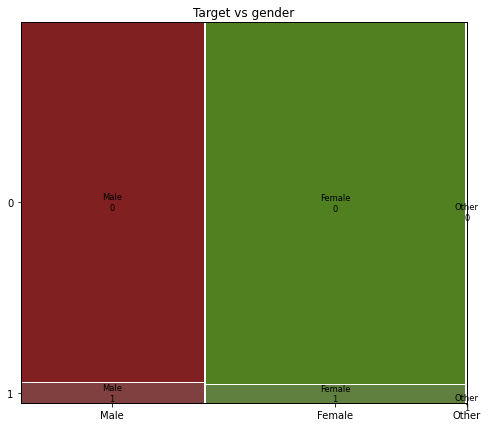

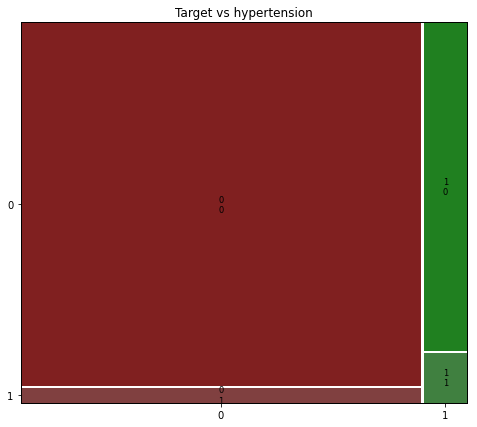

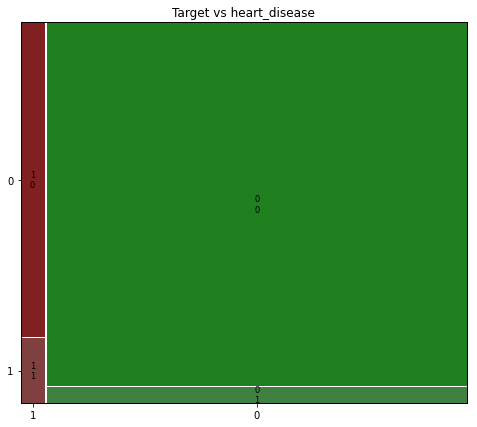

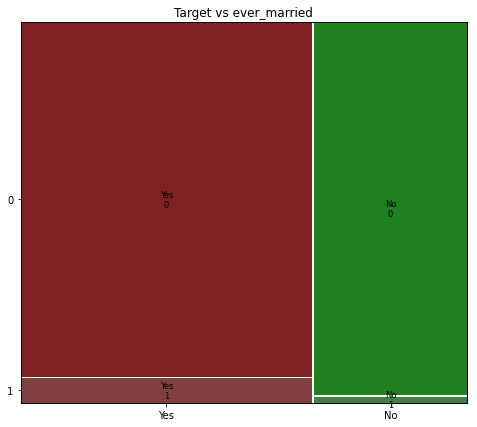

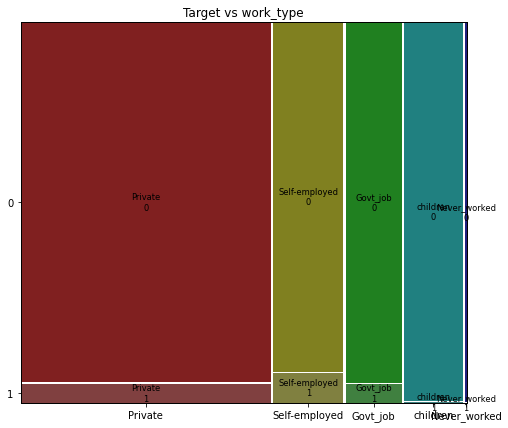

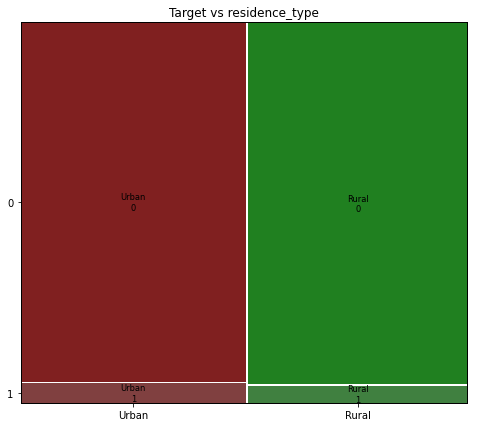

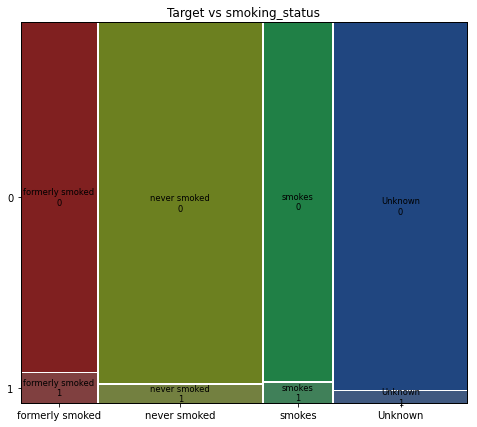

In [22]:
# plot target vs features using mosaic plot
plt_para_save = plt.rcParams['figure.figsize'] # remember plot settings

for f in features_cat:
    plt.rcParams["figure.figsize"] = (8,7) # increase plot size for mosaics
    mosaic(df, [f, 'target'], title='Target vs ' + f)
    plt.show()
    
# reset plot size again
plt.rcParams['figure.figsize'] = plt_para_save

"Naive" interpretations based on those univariate plots:
- Influence of gender seems surprisingly low.
- Hypertension and heart disease massively increase risk of stroke.
- "Ever married" too.
- Work type: Higher risk for self-employed (more stress).
- Residence type: Slightly higher risk for urban vs rural.
- Smoking: Highest risk for former smokers. Not much difference between "smokes" and "never smoked".

In [23]:
# "ever married" - check cross table
ctab = pd.crosstab(df.ever_married, df.target)
ctab

target,0,1
ever_married,,
No,1728,29
Yes,3133,220


In [24]:
# normalize each row
(ctab.transpose() / ctab.sum(axis=1)).transpose()

target,0,1
ever_married,,
No,0.983495,0.016505
Yes,0.934387,0.065613


# Build Model

In [25]:
# select predictors
predictors = features_num + features_cat
print('Number of predictors: ', len(predictors))
print(predictors)

Number of predictors:  10
['age', 'avg_glucose_level', 'bmi', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status']


In [26]:
# start H2O
h2o.init(max_mem_size='12G', nthreads=4) # Use maximum of 12 GB RAM and 4 cores

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 12.0.2+10, mixed mode, sharing)
  Starting server from C:\Users\ASUS\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ASUS\AppData\Local\Temp\tmpxcdd3uh7
  JVM stdout: C:\Users\ASUS\AppData\Local\Temp\tmpxcdd3uh7\h2o_ASUS_started_from_python.out
  JVM stderr: C:\Users\ASUS\AppData\Local\Temp\tmpxcdd3uh7\h2o_ASUS_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,"21 days, 8 hours and 26 minutes"
H2O_cluster_name:,H2O_from_python_ASUS_np7gl5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [27]:
# upload data frame in H2O environment
df_hex = h2o.H2OFrame(df)

df_hex['target'] = df_hex['target'].asfactor()

# train / test split (70/30)
train_hex, test_hex = df_hex.split_frame(ratios=[0.7], seed=999)

# pandas versions of train/test
df_train = train_hex.as_data_frame()
df_test = test_hex.as_data_frame()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [28]:
# export for potential external processing
df_train.to_csv('df_train.csv')
df_test.to_csv('df_test.csv')

In [29]:
# define Gradient Boosting model
fit_1 = H2OGradientBoostingEstimator(ntrees = 100,
                                     max_depth=4,
                                     min_rows=10,
                                     learn_rate=0.01, # default: 0.1
                                     sample_rate=1,
                                     col_sample_rate=0.7,
                                     nfolds=5,
                                     score_each_iteration=True,
                                     stopping_metric='auto',
                                     stopping_rounds=10,
                                     seed=999)

In [30]:
# train model
t1 = time.time()
fit_1.train(x=predictors,
            y='target',
            training_frame=train_hex)
t2 = time.time()
print('Elapsed time [s]: ', np.round(t2-t1,2))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Elapsed time [s]:  18.2


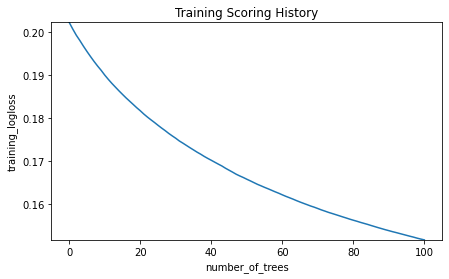

In [31]:
# show training scoring history
plt.rcParams['figure.figsize']=(7,4)
fit_1.plot()

In [32]:
# show cross validation metrics
fit_1.cross_validation_metrics_summary()


Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.88296235,0.026893046,0.8985314,0.8645418,0.920904,0.8767313,0.8541033
1,auc,0.8447821,0.015775004,0.8248061,0.85303646,0.8665343,0.8413103,0.83822346
2,aucpr,0.25358772,0.06440486,0.31334275,0.23784134,0.3262829,0.21365939,0.17681228
3,err,0.11703764,0.026893046,0.10146862,0.13545817,0.07909604,0.1232687,0.14589666
4,err_count,83.8,18.308468,76.0,102.0,56.0,89.0,96.0
5,f0point5,0.2743523,0.047999006,0.2827381,0.24691358,0.35460994,0.2375,0.25
6,f1,0.33863124,0.045371447,0.33333334,0.32,0.41666666,0.2992126,0.32394367
7,f2,0.44596684,0.042130653,0.4059829,0.45454547,0.5050505,0.40425533,0.46
8,lift_top_group,8.911059,4.9263487,14.04375,4.9539475,10.411765,12.534722,2.6111112
9,logloss,0.16763246,0.010467282,0.17238317,0.16395459,0.15365171,0.16623174,0.18194108



See the whole table with table.as_data_frame()


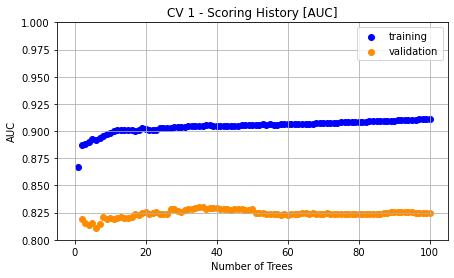

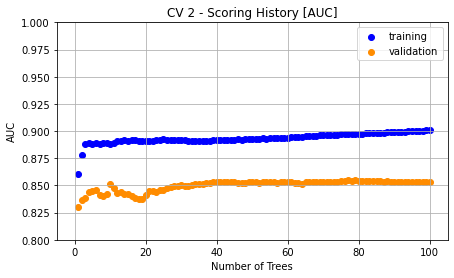

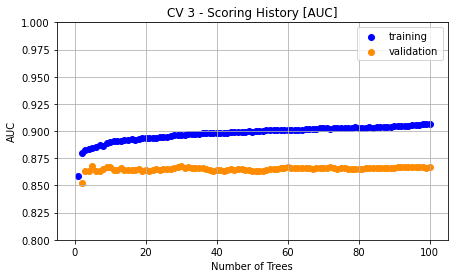

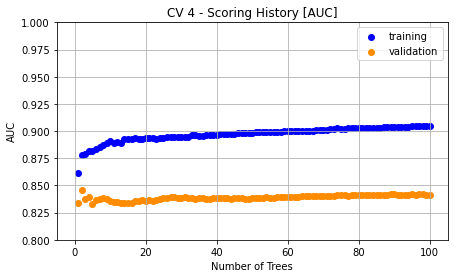

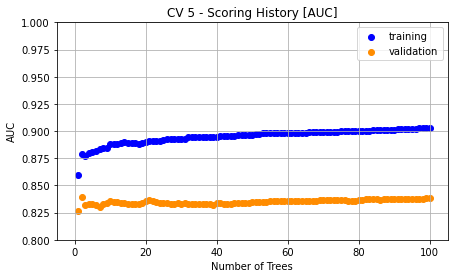

In [33]:
# show scoring history - training vs cross validations
for i in range(5):
    cv_model_temp = fit_1.cross_validation_models()[i]
    df_cv_score_history = cv_model_temp.score_history()
    my_title = 'CV ' + str(1+i) + ' - Scoring History [AUC]'
    plt.scatter(df_cv_score_history.number_of_trees,
                y=df_cv_score_history.training_auc, 
                c='blue', label='training')
    plt.scatter(df_cv_score_history.number_of_trees,
                y=df_cv_score_history.validation_auc, 
                c='darkorange', label='validation')
    plt.title(my_title)
    plt.xlabel('Number of Trees')
    plt.ylabel('AUC')
    plt.ylim(0.8,1)
    plt.legend()
    plt.grid()
    plt.show()

# Evaluate on Training Data

### ROC Curve - Training Data

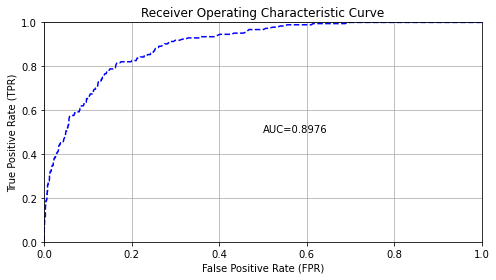

In [34]:
# training performance
perf_train = fit_1.model_performance(train=True)
perf_train.plot()

### ROC Curve - Cross Validation

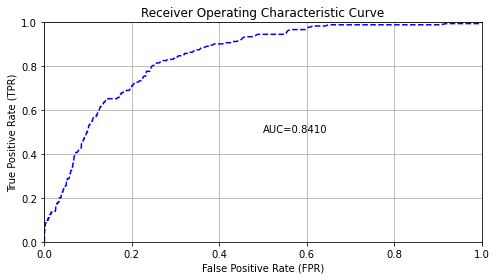

In [35]:
# cross validation performance
perf_cv = fit_1.model_performance(xval=True)
perf_cv.plot()

### Confusion Matrix

In [36]:
# on training data - automatic threshold (optimal F1 score)
conf_train = fit_1.confusion_matrix(train=True)
conf_train.show()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12790678230003902: 


,,0,1,Error,Rate
0,0,3209.0,197.0,0.0578,(197.0/3406.0)
1,1,79.0,105.0,0.4293,(79.0/184.0)
2,Total,3288.0,302.0,0.0769,(276.0/3590.0)


In [37]:
# corresponding accuracy for this threshold:
conf_list_temp = conf_train.to_list()
n_matrix = sum(conf_list_temp[0]) + sum(conf_list_temp[1])
acc_t0 = (conf_list_temp[0][0]+conf_list_temp[1][1]) / n_matrix
print('Accuracy:', np.round(acc_t0,6))

Accuracy: 0.92312


Selecting threshold by optimal F1 is not really helpful here, we have a big difference between actual positives (184) and predicted positives (302). Let's try to improve by selecting the threshold manually.

In [38]:
# alternatively specify threshold manually - here we try to achieve a symmetric outcome
tt = 0.148
conf_train_man = fit_1.confusion_matrix(train=True, thresholds=tt)
conf_train_man.show()

Could not find exact threshold 0.148; using closest threshold found 0.1478570244997902.

Confusion Matrix (Act/Pred) @ threshold = 0.1478570244997902: 


,,0,1,Error,Rate
0,0,3297.0,109.0,0.032,(109.0/3406.0)
1,1,108.0,76.0,0.587,(108.0/184.0)
2,Total,3405.0,185.0,0.0604,(217.0/3590.0)


In [39]:
# corresponding accuracy for manual threshold:
conf_list_temp = conf_train_man.to_list()
n_matrix = sum(conf_list_temp[0]) + sum(conf_list_temp[1]) 
acc_t1 = (conf_list_temp[0][0]+conf_list_temp[1][1]) / n_matrix
print('Accuracy:', np.round(acc_t1,6))

Accuracy: 0.939554


Much better result: 184 actual positives vs. 185 predicted positives.

In [40]:
# check on cross validation
conf_cv_man = fit_1.confusion_matrix(xval=True, thresholds=tt)
conf_cv_man.show()

Could not find exact threshold 0.148; using closest threshold found 0.14772756583508664.

Confusion Matrix (Act/Pred) @ threshold = 0.14772756583508664: 


,,0,1,Error,Rate
0,0,3266.0,140.0,0.0411,(140.0/3406.0)
1,1,143.0,41.0,0.7772,(143.0/184.0)
2,Total,3409.0,181.0,0.0788,(283.0/3590.0)


In [41]:
# corresponding accuracy for our manual threshold:
conf_list_temp = conf_cv_man.to_list()
n_matrix = sum(conf_list_temp[0]) + sum(conf_list_temp[1])
acc_t1_CV = (conf_list_temp[0][0]+conf_list_temp[1][1]) / n_matrix
print('Accuracy:', np.round(acc_t1_CV,6))

Accuracy: 0.92117


### Variable Importance

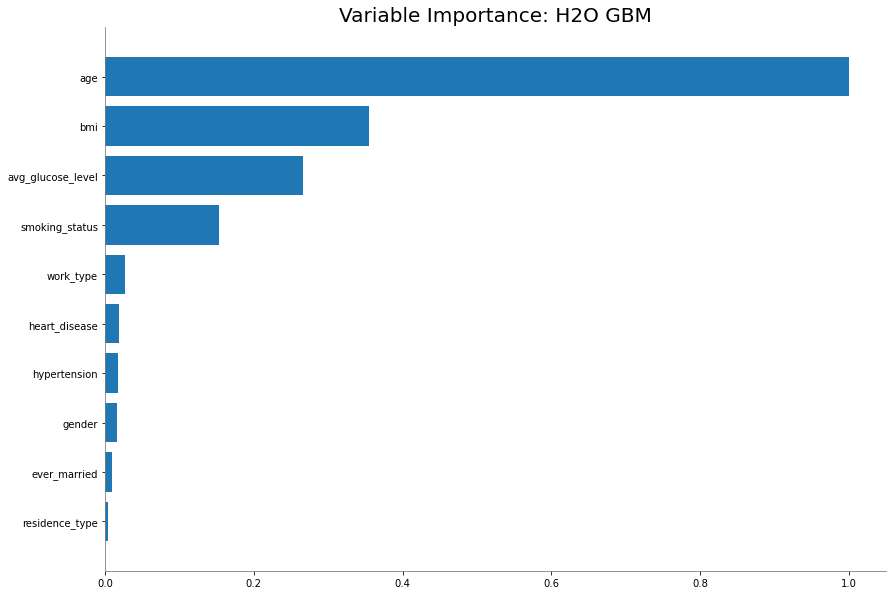

In [42]:
# basic version
fit_1.varimp_plot()

Elapsed time [s]:  1.21


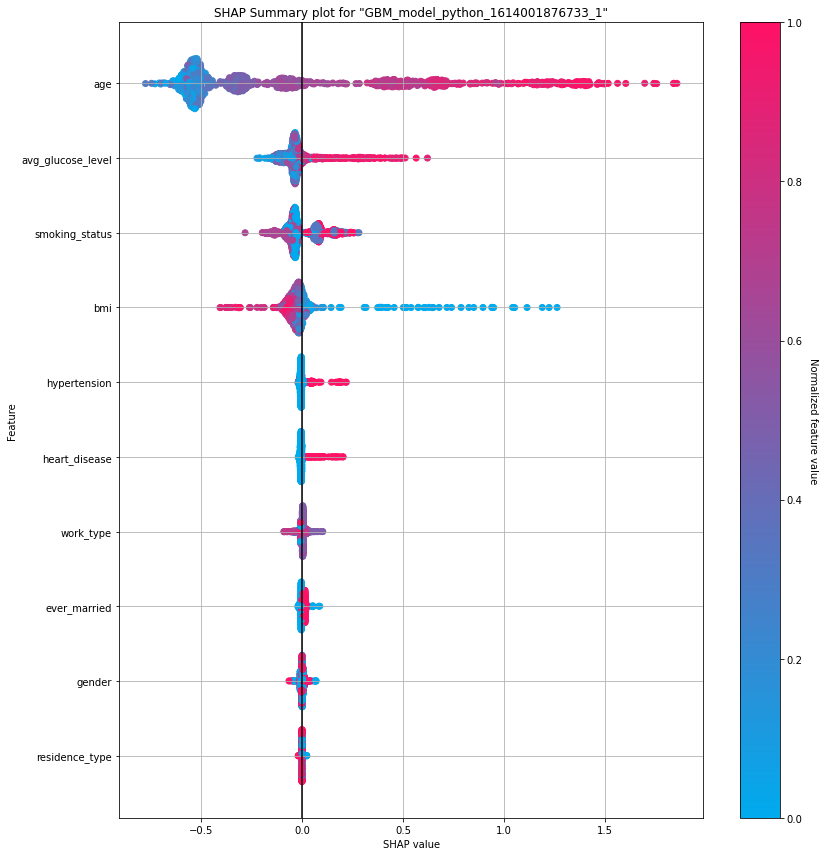

In [43]:
# variable importance using shap values => see direction as well as severity of feature impact
t1 = time.time()
fit_1.shap_summary_plot(train_hex);
t2 = time.time()
print('Elapsed time [s]: ', np.round(t2-t1,2))

The blue dots for BMI are probably a little bit confusing. They are based on the strongly predictive missing values which we have encoded with -99.

### Predictions on Training Data

gbm prediction progress: |████████████████████████████████████████████████| 100%


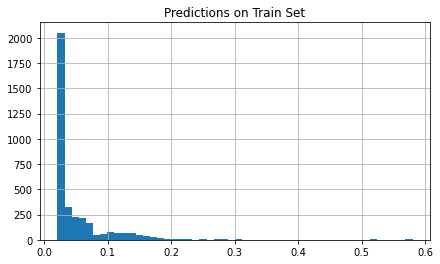

In [44]:
# predict on train set (extract probabilities only)
pred_train = fit_1.predict(train_hex)['p1']
pred_train = pred_train.as_data_frame().p1

# and plot
plt.hist(pred_train, bins=50)
plt.title('Predictions on Train Set')
plt.grid()
plt.show()

In [45]:
# check calibration
frequency_pred = sum(pred_train)
frequency_act = df_train.target.sum()
print('Predicted Frequency:', frequency_pred)
print('Actual Frequency   :', frequency_act)

Predicted Frequency: 184.400232283584
Actual Frequency   : 184


# Evaluate on Test Set

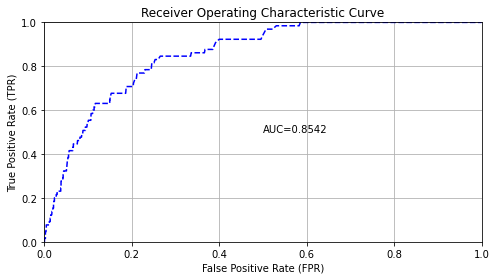

In [46]:
# calc performance on test test
perf_test = fit_1.model_performance(test_hex)

# ROC Curve - Test Set
perf_test.plot()

In [47]:
# confusion matrix using our manual threshold
conf_test_man = perf_test.confusion_matrix(thresholds=tt)
conf_test_man.show()

Could not find exact threshold 0.148; using closest threshold found 0.1480016916497603.

Confusion Matrix (Act/Pred) @ threshold = 0.1480016916497603: 


,,0,1,Error,Rate
0,0,1401.0,54.0,0.0371,(54.0/1455.0)
1,1,50.0,15.0,0.7692,(50.0/65.0)
2,Total,1451.0,69.0,0.0684,(104.0/1520.0)


Quite good result: 65 actual positives vs 69 predicted positives.

In [48]:
# calc accuracy for manual threshold:
conf_list_temp = conf_test_man.to_list()
n_matrix = sum(conf_list_temp[0]) + sum(conf_list_temp[1]) 
acc_t1_test = (conf_list_temp[0][0]+conf_list_temp[1][1]) / n_matrix
print('Accuracy:', np.round(acc_t1_test,6))

Accuracy: 0.931579


gbm prediction progress: |████████████████████████████████████████████████| 100%


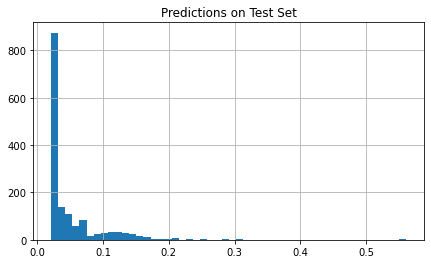

In [49]:
# predict on test set (extract probabilities only)
pred_test = fit_1.predict(test_hex)['p1']
pred_test = pred_test.as_data_frame().p1

# and plot
plt.hist(pred_test, bins=50)
plt.title('Predictions on Test Set')
plt.grid()
plt.show()

In [50]:
# connect prediction with data frame
df_test['prediction'] = pred_test

### Show Examples

In [51]:
# show most endangered patients (according to our model) in test set
df_high_20 = df_test.nlargest(20, columns='prediction')
df_high_20

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,target,age_bin,avg_glucose_level_bin,bmi_bin,prediction
475,17752,Male,76.0,0,1,Yes,Private,Urban,79.05,-99.0,Unknown,0,"(75.0, 82.0]","(73.8, 80.0]","(-100, 10]",0.561063
21,7356,Male,75.0,0,0,Yes,Private,Urban,104.72,-99.0,Unknown,1,"(65.0, 75.0]","(98.9, 108.5]","(-100, 10]",0.550400
553,1741,Male,77.0,0,0,Yes,Private,Urban,74.26,-99.0,formerly smoked,0,"(75.0, 82.0]","(73.8, 80.0]","(-100, 10]",0.545057
380,132,Female,80.0,0,0,Yes,Govt_job,Urban,84.86,-99.0,Unknown,0,"(75.0, 82.0]","(80.0, 85.6]","(-100, 10]",0.531739
686,1077,Male,77.0,0,1,Yes,Govt_job,Rural,106.03,-99.0,Unknown,0,"(75.0, 82.0]","(98.9, 108.5]","(-100, 10]",0.520791
14,15102,Male,78.0,1,0,Yes,Private,Urban,75.32,-99.0,formerly smoked,1,"(75.0, 82.0]","(73.8, 80.0]","(-100, 10]",0.517326
4,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,-99.0,Unknown,1,"(75.0, 82.0]","(192.2, 271.7]","(-100, 10]",0.305811
1483,10995,Male,76.0,1,0,Yes,Private,Rural,267.60,30.5,never smoked,0,"(75.0, 82.0]","(192.2, 271.7]","(30, 35]",0.305160
92,4480,Male,76.0,0,0,Yes,Private,Rural,234.58,34.3,formerly smoked,0,"(75.0, 82.0]","(192.2, 271.7]","(30, 35]",0.285260
6,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,-99.0,Unknown,1,"(51.0, 57.0]","(192.2, 271.7]","(-100, 10]",0.280943


Check calibration at high end.

In [52]:
print('Actual cases in highest 20    :', df_high_20.target.sum())
print('Predicted cases in highest 20 :', np.round(df_high_20.prediction.sum(),2))

Actual cases in highest 20    : 5
Predicted cases in highest 20 : 6.69


In [53]:
# show least endangered patients (according to our model) in test set
df_low_20 = df_test.nsmallest(20, columns='prediction')
df_low_20

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,target,age_bin,avg_glucose_level_bin,bmi_bin,prediction
788,57904,Male,15.0,0,0,No,Private,Urban,190.13,20.7,never smoked,0,"(11.0, 20.0]","(124.2, 192.2]","(20, 25]",0.020934
67,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0,"(11.0, 20.0]","(124.2, 192.2]","(10, 20]",0.020988
83,55680,Male,13.0,0,0,No,children,Urban,114.84,18.3,Unknown,0,"(11.0, 20.0]","(108.5, 124.2]","(10, 20]",0.020988
98,42996,Female,36.0,0,0,No,Govt_job,Rural,126.82,23.3,never smoked,0,"(30.0, 38.0]","(124.2, 192.2]","(20, 25]",0.020988
118,56681,Female,22.0,0,0,No,Private,Urban,130.34,22.0,never smoked,0,"(20.0, 30.0]","(124.2, 192.2]","(20, 25]",0.020988
125,34376,Female,16.0,0,0,No,children,Rural,113.47,19.5,Unknown,0,"(11.0, 20.0]","(108.5, 124.2]","(10, 20]",0.020988
143,22622,Male,10.0,0,0,No,children,Rural,108.79,21.0,Unknown,0,"(-0.020000000000000004, 11.0]","(108.5, 124.2]","(20, 25]",0.020988
161,61408,Male,23.0,0,0,No,Never_worked,Urban,125.26,18.7,never smoked,0,"(20.0, 30.0]","(124.2, 192.2]","(10, 20]",0.020988
175,20364,Female,4.0,0,0,No,children,Urban,107.25,12.0,Unknown,0,"(-0.020000000000000004, 11.0]","(98.9, 108.5]","(10, 20]",0.020988
254,32554,Female,16.0,0,0,No,children,Rural,109.02,19.8,Unknown,0,"(11.0, 20.0]","(108.5, 124.2]","(10, 20]",0.020988


Check calibration at low end.

In [54]:
print('Actual cases in lowest 20    :', df_low_20.target.sum())
print('Predicted cases in lowest 20 :', np.round(df_low_20.prediction.sum(),2))

Actual cases in lowest 20    : 0
Predicted cases in lowest 20 : 0.42
